# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Analyzing-data" data-toc-modified-id="Analyzing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyzing data</a></div><div class="lev2 toc-item"><a href="#Dependencies" data-toc-modified-id="Dependencies-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dependencies</a></div><div class="lev2 toc-item"><a href="#Batch-effect-approaches" data-toc-modified-id="Batch-effect-approaches-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Batch effect approaches</a></div><div class="lev3 toc-item"><a href="#No-batch-effect-compensation" data-toc-modified-id="No-batch-effect-compensation-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>No batch effect compensation</a></div><div class="lev3 toc-item"><a href="#Batch-effect-compensation-build-into-the-statistical-model" data-toc-modified-id="Batch-effect-compensation-build-into-the-statistical-model-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Batch effect compensation build into the statistical model</a></div><div class="lev3 toc-item"><a href="#Removing-batch-effects-using-ComBat" data-toc-modified-id="Removing-batch-effects-using-ComBat-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Removing batch effects using ComBat</a></div><div class="lev3 toc-item"><a href="#Estimating-surrogate-variables-and-using-these-to-remove-batch-effects" data-toc-modified-id="Estimating-surrogate-variables-and-using-these-to-remove-batch-effects-124"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Estimating surrogate variables and using these to remove batch effects</a></div><div class="lev2 toc-item"><a href="#Visualizations" data-toc-modified-id="Visualizations-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Visualizations</a></div><div class="lev2 toc-item"><a href="#Conclusions" data-toc-modified-id="Conclusions-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Conclusions</a></div><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Parse-input" data-toc-modified-id="Parse-input-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parse input</a></div><div class="lev1 toc-item"><a href="#Overview-visualization" data-toc-modified-id="Overview-visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overview visualization</a></div><div class="lev1 toc-item"><a href="#Differential-expression" data-toc-modified-id="Differential-expression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Differential expression</a></div><div class="lev2 toc-item"><a href="#Without-batch-correction" data-toc-modified-id="Without-batch-correction-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Without batch correction</a></div><div class="lev2 toc-item"><a href="#With-batch-correction" data-toc-modified-id="With-batch-correction-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>With batch correction</a></div><div class="lev1 toc-item"><a href="#Run-ComBat-to-adjust" data-toc-modified-id="Run-ComBat-to-adjust-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run ComBat to adjust</a></div><div class="lev2 toc-item"><a href="#ComBat-modelling-condition" data-toc-modified-id="ComBat-modelling-condition-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>ComBat modelling condition</a></div><div class="lev2 toc-item"><a href="#ComBat-PCA" data-toc-modified-id="ComBat-PCA-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ComBat PCA</a></div><div class="lev3 toc-item"><a href="#Calculate-statistics" data-toc-modified-id="Calculate-statistics-521"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Calculate statistics</a></div><div class="lev2 toc-item"><a href="#ComBat-not-modelling-biological-factor" data-toc-modified-id="ComBat-not-modelling-biological-factor-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>ComBat not modelling biological factor</a></div><div class="lev3 toc-item"><a href="#ComBat-without-condition-modelling-PCA" data-toc-modified-id="ComBat-without-condition-modelling-PCA-531"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>ComBat without condition-modelling PCA</a></div><div class="lev3 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-532"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Estimate-surrogate-variation" data-toc-modified-id="Estimate-surrogate-variation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Estimate surrogate variation</a></div><div class="lev2 toc-item"><a href="#Setup-model-matrices-and-estimate-number-of-surrogate-variables" data-toc-modified-id="Setup-model-matrices-and-estimate-number-of-surrogate-variables-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Setup model matrices and estimate number of surrogate variables</a></div><div class="lev2 toc-item"><a href="#Perform-surrogate-variation-analysis" data-toc-modified-id="Perform-surrogate-variation-analysis-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Perform surrogate variation analysis</a></div><div class="lev2 toc-item"><a href="#Calculate-significance-values" data-toc-modified-id="Calculate-significance-values-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Calculate significance values</a></div><div class="lev1 toc-item"><a href="#Summarize-significance" data-toc-modified-id="Summarize-significance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summarize significance</a></div>

# Analyzing data

In this part we explore how well we can distinguish spike-in protein despite batch effects when handling the batch effects in a variety of ways. The following are tried:


## Dependencies

This analysis is purely performed in R. It uses the following R- and BioConductor-packages:

* ggplot2
* ggfortify
* ggdendro
* gridExtra
* sva

It also uses custom scripts for generation and visualization of the PCA components.

## Batch effect approaches

###  No batch effect compensation

Contrasts are performed as there were no batch effect

### Batch effect compensation build into the statistical model

The data is unchanged but the batch effect is added as a confounding factor in the ANOVA model.

### Removing batch effects using ComBat

ComBat is a tool attempting to estimate and remove batch effects directly from the data. It produces a new dataset for which contrasts are performed without using confounding factor.

Batch effects are modelled in two ways. In one case, the ComBat model receives information about the different conditions present in the data. In the other, the batch effects are modelled without it. 

One voiced concern about ComBat is that it can give 'wishful results' creating differences where there are none based on the modelled conditions. This is the reasoning behind running it without the biological condition as included input.

### Estimating surrogate variables and using these to remove batch effects

When running ComBat we use a known factor to model batch effects. When estimating the surrogate variables we instead estimate it directly from the data. P-values are then estimated using this information in addition to the raw data.

## Visualizations

Here, I have used the PCA plot as my main tool to visualize the biological effect and the batch effect. In the unadjusted data, the batch effect clearly appears as the strongest effect being modelled by the principal component capturing 45% of the variation. The actual spike-in difference is modelled by the second, capturing 23% of the variance. 

After processing the data using ComBat the spike-in condition appears with the strongest effect showing 37% and 36% for data modelled with and without the condition levels.


## Conclusions

For this dataset, batch correction methods all resulted in a higher number of true positives  being detected. The problem was that the number of false positives increased 2-4 times compared to without applying the batch correction. In this particular dataset, it is hard to argue that one should use batch correction.

Out of the different methods used simply including the batch effect as a confounding factor in the statistical model was the method which included the least number of extra false positives. Although, the same effect could likely have been achieved by slightly adjusting the original threshold value.

It should be noted though that this is a quite 'sterile' simulated dataset. If using a more complex dataset, perhaps one where the difference between biological samples is less clear, this it might be that the approaches here show a better result. It clearly indicates though that one should tread carefully when performing further treatments to the data, and not take for granted that the used methods work as promised for all datasets.

# Setup

In [1]:
run <- "example_data"
expression_fp <- paste0(run, "/full_quant.tsv")
design_fp <- paste0(run, "/design.tsv")

In [2]:
source("util_scripts/proteomics_multivariate_vis.R")
source("util_scripts/visualization_utils.R")
#source("util_scripts/proteomics_stats.R")


In [3]:
library(ggplot2)
library(ggfortify)
library(ggdendro)
library(gridExtra)
library(sva)

source("util_scripts/proteomics_multivariate_vis.R")
source("util_scripts/visualization_utils.R")
#source("util_scripts/proteomics_stats.R")

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.
Loading required package: genefilter


In [4]:
plot_pca <- function(data_m, design_m, pc1, pc2, color_factor, colors, custom_names, legend=T, title_app="", cont_scale=F) {
    
    if (!cont_scale) {
        getPalette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))        
    }
    title <- paste0("PCA, PC", pc1, " vs PC", pc2, " ", title_app)
    plt <- make_expression_pca(data_m, design_m, color_factor=color_factor, title=title, 
                               pca_axis1=pc1, pca_axis2=pc2, show_labels=T,
                               only_text=T, color_text=T, custom_names=custom_names)
    if (!cont_scale) {
        plt <- plt + scale_color_manual(values=getPalette(colors))        
    }
    
    if (!legend) {
        plt <- plt + theme(legend.position="none")
    }
    
    plt
}

## Parse input

In [5]:
design_df <- read.csv(design_fp, sep="\t")
design_df$sample <- design_df$name
design_df$batch <- as.factor(design_df$batch)
print(design_df)

   name biorepgroup techrepgroup condition batch sample
1    a1           1            1         a     1     a1
2    a2           2            1         a     1     a2
3    a3           3            1         a     1     a3
4    a4           4            1         a     2     a4
5    a5           5            1         a     2     a5
6    a6           6            1         a     2     a6
7    b1           1            1         b     1     b1
8    b2           2            1         b     1     b2
9    b3           3            1         b     1     b3
10   b4           4            1         b     2     b4
11   b5           5            1         b     2     b5
12   b6           6            1         b     2     b6


In [34]:
raw_data_df <- read.csv(expression_fp, sep="\t")
head(raw_data_df)
raw_data_df$peptide <- as.character(raw_data_df$peptide)
raw_data_df$protein <- as.character(raw_data_df$protein)
data_df <- log2(raw_data_df[, as.character(design_df$name)])
head(data_df)

peptide,protein,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
CLK,sp|P37127|AEGA_ECOLI,27859100,47199200,48350400,87030800,64006700,66078900,36854100,21648000,29196300,72337000,73013000,74365200
FCR,sp|P0A7T7|RS18_ECOLI,140711604,102465796,120203200,175086700,200098700,179798000,119185600,210603108,166641100,135449704,169127700,168260400
LCR,sp|Q9JMR4|YUBK_ECOLI,49510300,59627600,34226700,61134400,79216496,65654900,41219500,50987400,55255100,80637000,77535504,96989904
FCQR,sp|P39357|YJHF_ECOLI,144461200,112001696,140922100,206195008,225476008,166140600,235997400,85933000,89382100,226930208,133279800,205833292
FLFK,sp|P34094|PHYB_SOLTU,99838500,109387700,138451200,202539600,163332600,157562700,227359600,250199192,231104092,408702200,366921216,383277616
FYLS,sp|A5A617|YDGU_ECOLI,81157104,71129400,51876400,109368000,99474200,98939400,92791800,95682704,88006096,213711,272874,290985


a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
24.73165,25.49226,25.52702,26.37502,25.93172,25.97769,25.13532,24.36773,24.79928,26.10823,26.12165,26.14812
27.06817,26.61057,26.84090,27.38349,27.57614,27.42180,26.82863,27.64995,27.31217,27.01318,27.33354,27.32612
25.56123,25.82948,25.02862,25.86548,26.23930,25.96840,25.29682,25.60364,25.71960,26.26494,26.20835,26.53133
27.10611,26.73895,27.07032,27.61943,27.74840,27.30783,27.81420,26.35671,26.41348,27.75767,26.98988,27.61690
26.57309,26.70488,27.04480,27.59363,27.28324,27.23135,27.76040,27.89850,27.78397,28.60647,28.45090,28.51381
26.27421,26.08394,25.62858,26.70462,26.56782,26.56004,26.46749,26.51175,26.39110,17.70530,18.05788,18.15059


In [35]:
parse_annot <- function(annot_string) {
    
    fields <- unlist(strsplit(as.character(annot_string), "/"))
    annot <- sapply(fields, function(field) { unlist(strsplit(field, "_"))[[2]] })
    
    if (annot == "SOLTU") {
        TRUE
    }
    else if (annot == "ECOLI") {
        FALSE
    }
    else {
        stop(paste0("Unknown annotation: ", annot))
    }
}

In [36]:
spike_col <- sapply(as.character(raw_data_df[, "protein"]), parse_annot)
head(spike_col)


sp|P37127|AEGA_ECOLI sp|P0A7T7|RS18_ECOLI sp|Q9JMR4|YUBK_ECOLI 
               FALSE                FALSE                FALSE 
sp|P39357|YJHF_ECOLI sp|P34094|PHYB_SOLTU sp|A5A617|YDGU_ECOLI 
               FALSE                 TRUE                FALSE

# Overview visualization

Clustering of unadjusted based on main principal components. Conditions are distinguished 'a' and 'b', while batches are distinguished by color.

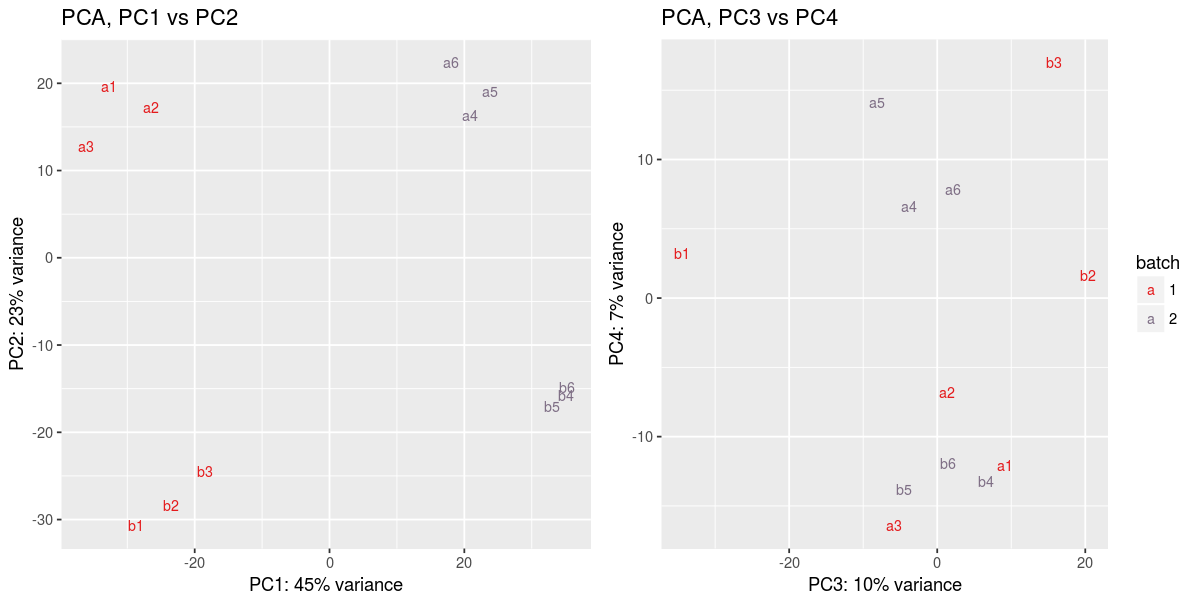

In [37]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F)
p1_2 <- plot_pca(data_df, design_df, 3, 4, "batch", colors=4, custom_names=design_df$name, legend=T)
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


# Differential expression

Differential expression is performed by applying an ANOVA comparing the samples from condition 'a' and condition 'b'. This is performed both without and with compensation for the batch factor.

Here, vectors with the calculated q-values for each method are stored in the list `q_vectors`. The true/false call for a significance threshold of 0.1 is stored in the list `sig_vectors`.

In [10]:
sig_vectors <- list()
q_vectors <- list()

In [11]:
calculate_anova <- function(row, cond, batch=NULL) {
    
    if (!is.null(batch)) {
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond, Batch=batch))        
        av <- aov(Intensity~Cond+Batch, anova_df)        
    }
    else {
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond))
        av <- aov(Intensity~Cond, anova_df)                
    }
    
    av_summary <- summary(av)
    p_val <- av_summary[[1]]["Cond", "Pr(>F)"]
    p_val
}

The `truth_vector` takes two vectors with booleans. The first shows to if a feature has been measured as true or false. The second shows if the feature actually is differentially expressed (i.e. if it is a spike-in feature). It is then assigned a string showing whether it was a true/false call of a positive or negative.

This vector is then used to print all the numbers, as well as calculating the measures:

* Specificity
* Precision
* Recall
* F1-score, defined as 2 \* (precision \* recall) / (precision + recall)

In [52]:
get_truth_vector <- function(measured_pos_vect, actually_pos_vect) {
    
    truth_vector <- c()
    
    for (i in 1:length(measured_pos_vect)) {
        
        measured_pos <- measured_pos_vect[i]
        actually_pos <- actually_pos_vect[i]
        
        if (measured_pos && actually_pos) {
            outcome <- "TP"
        }
        else if (!measured_pos && !actually_pos) {
            outcome <- "TN"
        }
        else if (measured_pos && !actually_pos) {
            outcome <- "FP"
        }
        else if (!measured_pos && actually_pos) {
            outcome <- "FN"
        }
        else {
            stop(paste("Unknown state, measured_pos:", measured_pos, 
                       ", actually_pos:", actually_pos))
        }
        
        truth_vector <- c(truth_vector, outcome)
    }
    
    truth_vector
}

print_truth_summary <- function(truth_vector) {
    
    truth_table <- table(truth_vector)
    print(truth_table)
    
    FN <- truth_table["FN"]
    FP <- truth_table["FP"]
    TN <- truth_table["TN"]
    TP <- truth_table["TP"]
    
    specificity <- TN / (TN + FP)
    precision <- TP / (TP + FP)
    recall <- TP / (TP + FN)
    fscore <- 2 * (precision * recall) / (precision + recall)
    
    print(paste("Precision:", round(precision, 3)))
    print(paste("Specificity:", round(specificity, 3)))
    print(paste("Recall:", round(recall, 3)))
    print(paste("F-score:", round(fscore, 3)))
}

get_truth_summary_vector <- function(truth_vector) {
    
    truth_table <- table(truth_vector)
#     print(truth_table)
    
    TP <- truth_table["TP"]
    TN <- truth_table["TN"]
    FP <- truth_table["FP"]
    FN <- truth_table["FN"]
    
    specificity <- TN / (TN + FP)
    precision <- TP / (TP + FP)
    recall <- TP / (TP + FN)
    fscore <- 2 * (precision * recall) / (precision + recall)
  
    sum_v <- c(TP, TN, FP, FN, specificity, precision, recall, fscore)
    names(sum_v) <- c("TP", "TN", "FP", "FN", "specificity", "precision", "recall", "fscore")
    sum_v
    
#     print(paste("Precision:", round(precision, 3)))
#     print(paste("Specificity:", round(specificity, 3)))
#     print(paste("Recall:", round(recall, 3)))
#     print(paste("F-score:", round(fscore, 3)))
}

## Without batch correction

Calculating differential expression on data without any batch-effect compensation.

In [39]:
p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)
truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)

sig_vectors[["default"]] <- truth_vector
q_vectors[["default"]] <- q_vals

## With batch correction

Calculating differential expression including the batch effect as a factor used for the ANOVA model.

In [40]:
p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition, batch=design_df$batch))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
sig_vectors[["batch_corr"]] <- truth_vector
q_vectors[["batch_corr"]] <- q_vals

# Run ComBat to adjust

ComBat is an algorithm attempting to remove batch effects from expression data. It takes a factor distinguishing the known batch effect levels. It produces a new dataset which then in turn is used for differential expression between the conditions.

## ComBat modelling condition

Here, the condition is included in the ComBat modelling.

In [15]:
modcombat <- model.matrix(~1+condition, data=design_df)
modcombat

,(Intercept),conditionb
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,1
8,1,1
9,1,1
10,1,1


Found 2 batches
Adjusting for 1 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


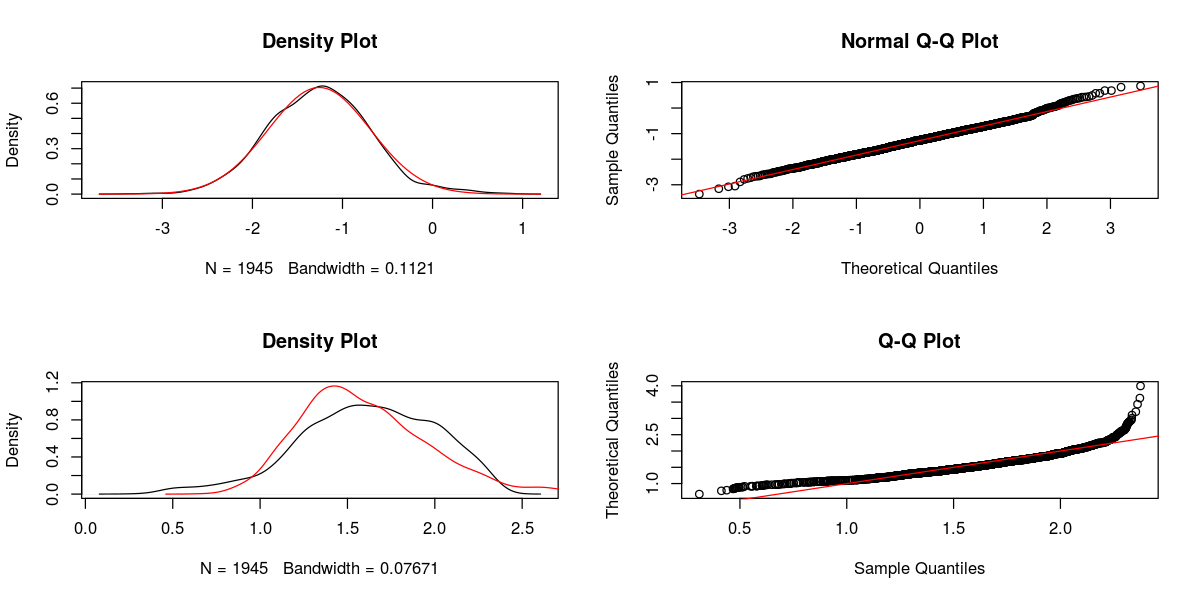

In [16]:
combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

In [17]:
head(combat_data_df)

a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
25.29990,25.89727,25.92457,25.91697,25.37234,25.42881,25.56847,24.96562,25.30455,25.64082,25.65731,25.68983
27.26883,26.90736,27.08931,27.19215,27.41855,27.23717,27.09931,27.74809,27.48127,26.74052,27.11701,27.10830
25.84725,26.05939,25.42607,25.50047,25.95178,25.62473,25.67764,25.92027,26.01197,25.94362,25.87531,26.26524
27.44510,27.15594,27.41692,27.27336,27.43068,26.89326,27.98002,26.83217,26.87688,27.46552,26.52895,27.29380
26.88014,26.98467,27.25429,27.33587,26.99732,26.94073,28.04881,28.15835,28.06750,28.34106,28.17137,28.24000
26.49451,26.34706,25.99420,26.91221,26.78047,26.77298,25.72382,25.75812,25.66463,18.09454,18.43407,18.52335


## ComBat PCA

Here, we visualize how the PCA plot for the ComBat processed data compare to the unprocessed data (looking at the two major principal components).

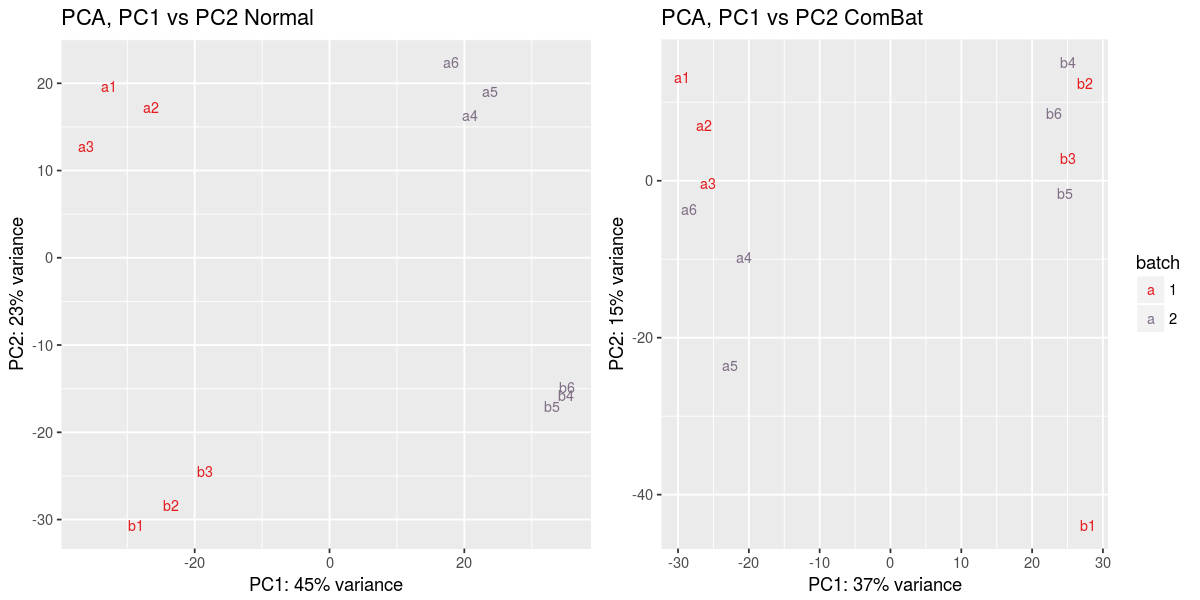

In [18]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app="Normal")
p1_2 <- plot_pca(combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Calculate statistics

In [42]:
p_vals <- unlist(apply(combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
sig_vectors[["combat"]] <- truth_vector
q_vectors[["combat"]] <- q_vals

## ComBat not modelling biological factor

In order to investigate whether how ComBat uses the known condition differences I tried running it without any other information than the batch differences.

Found 2 batches
Adjusting for 0 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


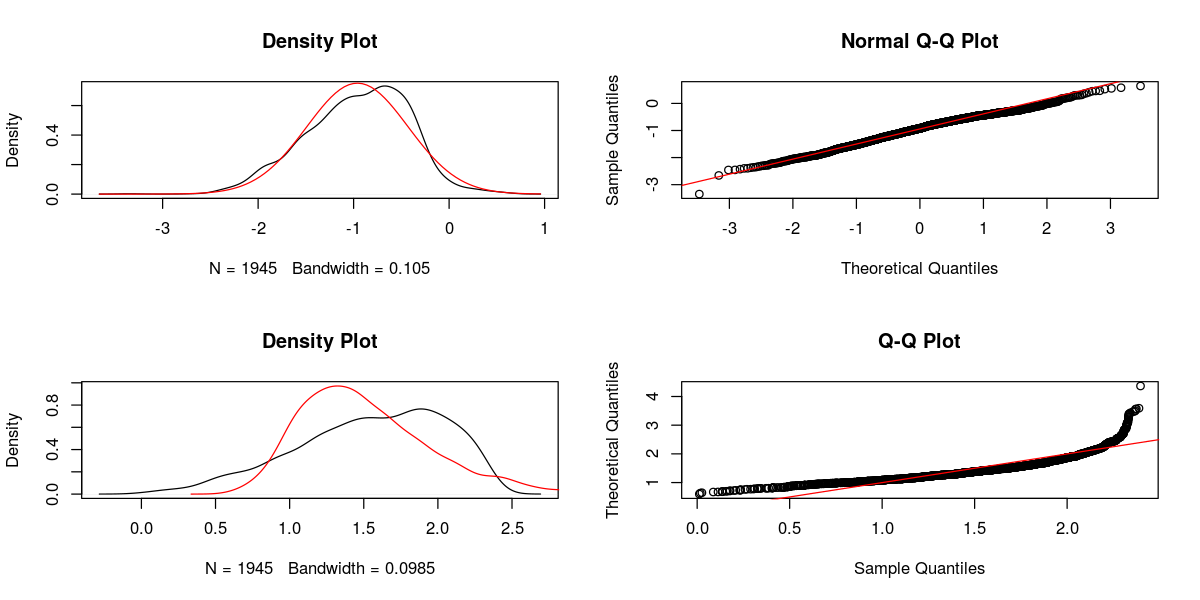

In [44]:
modcombat <- model.matrix(~1, data=design_df)
only_int_combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

### ComBat without condition-modelling PCA

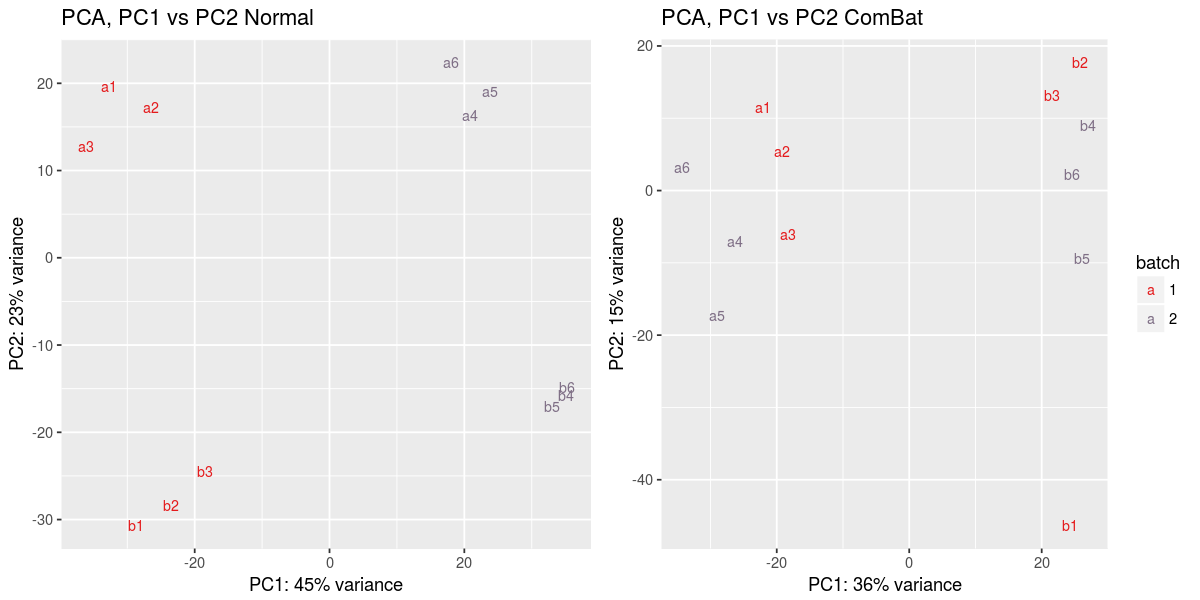

In [22]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app = "Normal")
p1_2 <- plot_pca(only_int_combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Statistics

In [45]:
p_vals <- unlist(apply(only_int_combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
sig_vectors[["combat_no_factor"]] <- truth_vector
q_vectors[["combat_no_factor"]] <- q_vals

# Estimate surrogate variation

An alternative to using ComBat to model known batch levels is to estimate the 'surrogate variation' directly from the data.

## Setup model matrices and estimate number of surrogate variables

In [48]:
mod <- model.matrix(~condition, data=design_df)
mod0 <- model.matrix(~1, data=design_df)

## Perform surrogate variation analysis

In [49]:
n.sv <- num.sv(data_df, mod, method="leek")
data_m <- as.matrix(data_df)
svobj <- sva(data_m, mod, mod0, n.sv=n.sv)

Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

## Calculate significance values

In [50]:
pValues <- f.pvalue(data_m, mod, mod0)
qValues <- p.adjust(pValues, method="BH")

modSv <- cbind(mod, svobj$sv)
mod0Sv <- cbind(mod0, svobj$sv)
pValuesSv <- f.pvalue(data_m, modSv, mod0Sv)
qValuesSv <- p.adjust(pValuesSv, method="BH")

In [47]:
truth_vector <- get_truth_vector(measured_pos_vect=qValuesSv < 0.1, actually_pos_vect=spike_col)
sig_vectors[["sva"]] <- truth_vector
q_vectors[["sva"]] <- qValuesSv

# Summarize significance

Display of the number of identified positives (and number of true positives), as well as summary of important significance measures.

In [51]:
print(paste("True positives:", length(spike_col[spike_col])))
print("Sig counts:")
for (name in names(q_vectors)) {
    q_vector <- q_vectors[[name]]
    print(paste0(name, ": ", length(q_vector[which(q_vector < 0.1)])))
}

[1] "True positives: 424"
[1] "Sig counts:"
[1] "default: 505"
[1] "batch_corr: 754"
[1] "combat: 867"
[1] "combat_no_factor: 817"
[1] "sva: 947"


In [88]:
truth_summary_table <- data.frame(matrix(NA, nrow=0, ncol=8))

# print(truth_summary_table)

for (sig_v in names(sig_vectors)) {
    sum_v <- data.frame(get_truth_summary_vector(sig_vectors[[sig_v]]))
#     colnames(sum_v) <- sig_v
#     print(sum_v)
#     print(sum_v)
#     rownames(sum_v) <- sig_v
#     print(truth_summary_table)
#     print(sum_v)
    sum_row <- unlist(sum_v)
#     names(sum_row) <- "test"
    
    truth_summary_table <- rbind(truth_summary_table, sum_row)
#     truth_summary_table <- cbind(truth_summary_table, sum_v)
}

colnames(truth_summary_table) <- c("TP", "TN", "FP", "FN", "specificity", "precision", "recall", "fscore")
rownames(truth_summary_table) <- names(sig_vectors)

truth_summary_table

,TP,TN,FP,FN,specificity,precision,recall,fscore
default,348,1364,157,76,0.8967784,0.6891089,0.8207547,0.7491927
batch_corr,379,1146,375,45,0.7534517,0.5026525,0.8938679,0.6434635
combat,385,1039,482,39,0.6831032,0.4440600,0.9080189,0.5964369
combat_no_factor,386,1090,431,38,0.7166338,0.4724602,0.9103774,0.6220790
sva,394,968,553,30,0.6364234,0.4160507,0.9292453,0.5747629
